In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and Reshape Training data**

In [ ]:
import scipy.io
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
train_data = scipy.io.loadmat('/content/drive/My Drive/stat-learning/train_data.mat')

In [ ]:
train_data_x = train_data['x']
print("Shape of Training images")
print(train_data_x.shape)
train_data_x = np.reshape(train_data_x,(train_data_x.shape[0],train_data_x.shape[1]*train_data_x.shape[2]))
print("Shape after flattening")
print(train_data_x.shape)

Shape of Training images
(12000, 28, 28)
Shape after flattening
(12000, 784)


**Covariance matrix calculation and PCA definition**

In [ ]:
def cov(data):
  N=data.shape[0]
  data_mean = data.mean(axis=0)[np.newaxis,:]
  std_dev = np.sqrt(np.sum(np.square((data-data_mean)),axis=0)/(N-1))[np.newaxis,:]
  data_normal = np.divide((data-data_mean),std_dev,out=np.zeros_like(data-data_mean,dtype=np.float64),where=std_dev!=0)
  cov_matrix = np.matmul(data_normal.T,data_normal)/(N-1)
  return cov_matrix.astype(np.float64), data_mean, std_dev

def PCA(data):
  cov_matrix, data_mean, std_dev = cov(data)
  print("Shape of cov matrix:"+str(cov_matrix.shape), "Shape of mean vector:"+str(data_mean.shape), "Shape of standard deviation:"+str(std_dev.shape))
  eigen_val, eigen_vec = np.linalg.eigh(cov_matrix)
  print("No of eigen values:",eigen_val.shape)
  print("Shape of matrix of eigen vectors:",eigen_vec.shape)
  eigen_val = eigen_val[-1::-1]
  eigen_vec = eigen_vec[:,-1::-1]
  eigen_val[eigen_val<0] = 0
  return eigen_val,eigen_vec, data_mean, std_dev

**Calculating the principal components and eigen values of the training data**

In [ ]:
eigen_values, eigen_vectors, mean, std_dev = PCA(train_data_x)

Shape of cov matrix:(784, 784) Shape of mean vector:(1, 784) Shape of standard deviation:(1, 784)
No of eigen values: (784,)
Shape of matrix of eigen vectors: (784, 784)


**Data normalization and projection onto top 2 Principal Components**

In [ ]:
train_data_norm = (train_data_x-mean)/std_dev
print("Data before projection -")
print(train_data_norm.shape)
train_data_2d = np.matmul(train_data_norm,eigen_vectors[:,:2])
print("Data after projection -")
print(train_data_2d.shape)

Data before projection -
(12000, 784)
Data after projection -
(12000, 2)


**Plotting the 2 classes in the reduced 2D space**

In [ ]:
labels = train_data['y'].squeeze()
shirt_data_2d = train_data_2d[labels==0]
sneakers_data_2d = train_data_2d[labels==1]

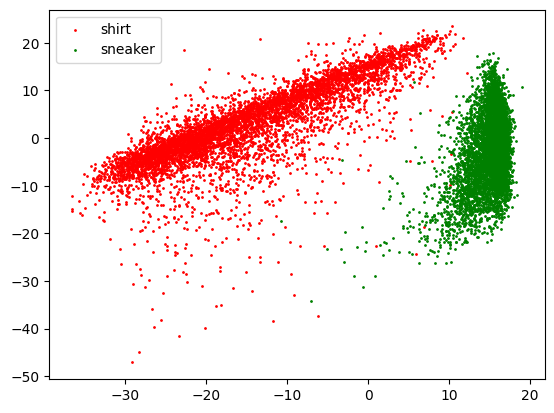

In [ ]:
plt.scatter(shirt_data_2d[:,0], shirt_data_2d[:,1], s=1,c='r',label='shirt')
plt.scatter(sneakers_data_2d[:,0], sneakers_data_2d[:,1],s=1, c='g',label='sneaker')
plt.legend()
plt.show()

**Calculating MLE Estimate for the 2 classes**

In [ ]:
shirt_mu = shirt_data_2d.mean(axis=0)[np.newaxis,:]
print("MLE mean shirt-")
print(shirt_mu)
N = shirt_data_2d.shape[0]
shirt_sigma = np.matmul((shirt_data_2d-shirt_mu).T,(shirt_data_2d-shirt_mu))/N
print("MLE Sigma shirt-")
print(shirt_sigma)

MLE mean shirt-
[[-14.95951243   2.53749139]]
MLE Sigma shirt-
[[103.35625586  69.13932645]
 [ 69.13932645  73.41582531]]


In [ ]:
sneakers_mu = sneakers_data_2d.mean(axis=0)[np.newaxis,:]
print("MLE mean sneakers-")
print(sneakers_mu)
N = sneakers_data_2d.shape[0]
sneakers_sigma = np.matmul((sneakers_data_2d-sneakers_mu).T,(sneakers_data_2d-sneakers_mu))/N
print("MLE sigma sneakers-")
print(sneakers_sigma)

MLE mean sneakers-
[[14.95951243 -2.53749139]]
MLE sigma sneakers-
[[ 4.9453332   6.7799416 ]
 [ 6.7799416  54.66106369]]


**Log Discriminant Function**

In [ ]:
def g(X, mu, sigma):
  result = np.sum(np.matmul((X-mu),np.linalg.inv(sigma))*(X-mu),axis=1)/(-2) - np.log(np.linalg.det(sigma))/2
  return result

**Training set classification**

In [ ]:
# Calculating the value of the shirt and sneaker discriminant functions for all input points
train_pred = np.concatenate((g(train_data_2d,shirt_mu,shirt_sigma)[:,np.newaxis],g(train_data_2d,sneakers_mu,sneakers_sigma)[:,np.newaxis]),axis=1)
# Taking the catergory with bigger discriminant function as prediction
train_pred = np.argmax(train_pred,axis=1)
N = train_pred.shape[0]
accuracy_train = (1-(np.sum(np.abs(train_pred-labels))/N))*100
print("Training accuracy-"+ str(accuracy_train))

Training accuracy-99.75


**Loading and Preprocessing Test Data**

In [ ]:
test_data = scipy.io.loadmat('/content/drive/My Drive/stat-learning/test_data.mat')

In [ ]:
test_data_x = test_data['x']
print("Shape of Test images")
print(test_data_x.shape)
test_data_x = np.reshape(test_data_x,(test_data_x.shape[0],test_data_x.shape[1]*test_data_x.shape[2]))
print("Shape of Test images after flattening")
print(test_data_x.shape)

Shape of Test images
(2000, 28, 28)
Shape of Test images after flattening
(2000, 784)


**Normalization of test data and projection onto top 2 principal components**

In [ ]:
test_data_norm = (test_data_x-mean)/std_dev
print("original dimensions of the test data")
print(test_data_norm.shape)
test_data_2d = np.matmul(test_data_norm,eigen_vectors[:,:2])
print("Test data after dimensionality reduction")
print(test_data_2d.shape)
test_labels = test_data['y'].squeeze()

original dimensions of the test data
(2000, 784)
Test data after dimensionality reduction
(2000, 2)


**Test data classification**

In [ ]:
# Calculating the value of the shirt and sneaker discriminant functions for all input points
test_pred = np.concatenate((g(test_data_2d,shirt_mu,shirt_sigma)[:,np.newaxis],g(test_data_2d,sneakers_mu,sneakers_sigma)[:,np.newaxis]),axis=1)
# Taking the catergory with bigger discriminant function as prediction
test_pred = np.argmax(test_pred,axis=1)
N = test_pred.shape[0]
# Calculating accuracy
accuracy_test = (1-(np.sum(np.abs(test_pred-test_labels))/N))*100
print("Test accuracy-"+str(accuracy_test))

Test accuracy-99.9


In [ ]:
import json
#store the eigen vectors, train and test predictions
with open('/content/drive/My Drive/stat-learning/eigen_vectors_mnist.json','w') as fd:
  json.dump({"eigen_vectors":eigen_vectors.tolist(), "eigen_values":eigen_values.tolist()},fd)
with open('/content/drive/My Drive/stat-learning/predictions_mnist.json','w') as fd:
  json.dump({"train_predictions":train_pred.tolist(), "test_predictions":test_pred.tolist()},fd)